# PetroGeoSim
### Подсчет запасов методом Монте-Карло в Python

In [1]:
import matplotlib.pyplot as plot

from PetroGeoSim.models import Model
from PetroGeoSim.properties import Property
from PetroGeoSim.templates import Templates
from PetroGeoSim.regions import Region
from PetroGeoSim.visualization import *
from PetroGeoSim.config_maker import config_maker

Можно загрузить шаблоны переменных с русскими незваниями (пока нет применения толком)

In [2]:
temp = Templates()

In [3]:
temp.load('en')

Чтобы посмотреть доступные вызовем show()

In [4]:
temp.show()

Inputs:
* Areas
* Total thickness
* Reservoir thickness
* Porosity
* Oil saturation
* Water saturation
* Net-to-gross
* Formation volume factor
* Expansion factor
* Oil density
* Geometric correction factor
* Top depth
* Bottom depth
* Oil-water contact
* Gas-water contact
Results:
* Total hydrocarbons in-place


get() возвращает словарь с инициализированными переменными и их названиями, чтобы можно было записать их в удобные переменные

In [5]:
save = temp.get('Водонасыщенность', 'ВНК')

Found invalid template name: Водонасыщенность
Skipping...
Found invalid template name: ВНК
Skipping...


# 1. Модель

С PetroGeoSim можно создавать модели как с одним регионом, так и с несколькими, при этом для каждого можно задать свои параметры, распределения и результирующие параметры. Для удобства обращения расчета и обращения с ними и предоставляется класс-контейнер Model.

In [6]:
# seed = 300


Создадим модель с следующими параметрами: Название, зерно (seed), краткое описание

In [7]:
model = Model("Total hydrocarbons in-place", 300, 100000)  # model = Model(name="Total hydrocarbons in-place", seed=300, num_samples="A simple reservoir model")

Можно проверить параметры только что созданной нами модели

In [8]:
print(model)

MODEL "OOIP test"
* Seed: 300
* Number of samples: 100000
* Regions: 
* Properties: 


В модели содержатся два основных компонента: регионы и индивидуальные свойства/параметры.
Через API модели могут осуществляться следующие действия:
* Добавление регионов и свойств;
* Контроль за cлучайным зерном модели и свойств;
* Сэмплинг из распределений для входных параметров; 
* Получение доступа к аттрибутам регионов и параметров и т.д.  
Так же доступ может осуществляться напрямую, что, однако, не рекомендуется (пока сложности с обновление параметров после инициализации и удалением/очисткой).

Регионы содержат в себе все свойства модели и для каждого из них свойства модели могут варьироваться.

Расчеты можно также производить независимо (не используя модель), но модель предоставляет более удобные для этого интерфейсы.

# 2. Регионы

Поскольку мы уже создали модель, теперь можно создать несколько регионов модели, которые будут использоваться для "хранения" наших случайных величин (параметров).  
Создадим 3 региона, указав: их названия и состав (в случае если он важен).  
__ВАЖНО__: имя является уникальным идентификатором региона, то есть нельзя добавить два региона с полностью одинаковыми именами

In [9]:
region_a = Region("A", "Sandstone") # region_a = Region(name="A", composition="Sandstone")
region_b = Region("B", "Carbonate") # region_b = Region(name="B", composition="Carbonate")
region_c = Region("C", "Dolomite") # region_c = Region(name="C", composition="Dolomite")

Теперь добавим их в модель. Можно указать все регионы в виде позиционных аргументов функции

In [10]:
model.add_regions(region_a, region_b, region_c)

Или добавить их все последовательно командой add_region()

In [11]:
# model.add_region(region_a)
# model.add_region(region_b)
# model.add_region(region_c)

MontePetro already comes with a number of properties types that we can define for our model.
RandomProperties are computed contain sets of values that we can sample from probability distributions.
RegionalProperties are properties that we want to calculate based on the defined properties of our model.

For our reservoir we want to estimate the oil in place distribution of our reservoir.
We define a simplistic oil in place as:

$$V = A*H*NTG*Poro*G*S_{o}*\frac{1}{B_{o}}$$

Where we assume Height and NetToGross to be 1.
The following code goes into detail on how we create the probability distributions and add them to our model.

# 3. Случайные переменные (параметры)

Для расчета запасов (или любой другой результирующей величины), необходимо задать исходные случайные величины, путем перемножения которых будет получаться интересующая нас конечная оценка.

Для этого зададим количество точек (сэмплов), которые мы хотим отобрать из наших распределений. Этот параметр будет (и должен быть) единым для всех распределений, чтобы можно было выполнять математические операции над полученными числами.

In [12]:
# s = RandomProperty(name="Площадь", num_samples=n, distribution='uniform')
# h = RandomProperty(name="Общая мощность", num_samples=n, distribution="normal")
# hef = RandomProperty(name="Эффективная мощность", num_samples=n, distribution="normal")
# poro = RandomProperty(name="Пористость", num_samples=n, distribution="normal")
# s_o = RandomProperty(name="Нефтенасыщенность", num_samples=n, distribution='triangular')
# s_w = RandomProperty(name="Водонасыщенность", num_samples=n, distribution='triangular')
# ntg = RandomProperty(name="Коэффициент песчанистости", num_samples=n, distribution='triangular')
# fvf = RandomProperty(name="Объемный коэффициент", num_samples=n, distribution='triangular')
# per = RandomProperty(name="Объемный коэффициент", num_samples=n, distribution='triangular') # =1/fvf
# den = RandomProperty(name="Плотность нефти", num_samples=n, distribution='triangular')
# geomf = RandomProperty(name="Геометрический фактор", num_samples=n, distribution='triangular')
# top_depth = RandomProperty(name="Кровля пласта", num_samples=n, distribution='triangular')
# top_depth = RandomProperty(name="Подошва пласта", num_samples=n, distribution='triangular')
# owc = RandomProperty(name="ВНК", num_samples=n, distribution='triangular')
# gwc = RandomProperty(name="ГНК", num_samples=n, distribution='triangular')

Создаем переменные которые нам нужны для расчета, в данном случае запасов.  
Для каждого параметра указываем: название, тип распределения (на английском), количество сэмплов __[Это надо поправить и убрать в модель, примечание себе]__  
__ВАЖНО__: имя также является уникальным идентификатором параметра, то есть нельзя добавить два параметра с полностью одинаковыми именами.

In [13]:
area = Property("Area", distribution="uniform") # area = RandomProperty(name="Area", distribution="uniform", num_samples=n)
porosity = Property("Porosity", distribution="truncated normal") # porosity = RandomProperty(name="Porosity", distribution="truncated normal", num_samples=n)
sw = Property("Sw", distribution="triangular") # sw = RandomProperty(name="Sw", distribution="triangular", num_samples=n)

Доступные на данный момент распределения:
* __Равномерное (uniform)__
* __Нормальное (normal)__
* __Бета (beta)__
* __Логнормальное (lognormal)__
* __Треугольное (triangular)__
* __Усеченное нормальное (truncated normal)__

Добавляем созданные параметры в модель, указывая регион, при этом регион. 
Функция принимает на вход словарь, где ключ - объект параметра, а значения могут иметь следующие варианты:  
* 'all' - добавить ко всем регионам
* Список или массив из названий регионов ('A', 'B', 'C') - добавить к указанным регионам
* Одно название региона (строка) ('A') - добавить только к указанному региону

In [14]:
model.add_properties(
    {area: 'all', 
     porosity: ('A', 'B', 'C'), 
     sw: ['A', 'B', 'C']}
)

ИЛИ

In [15]:
# model.add_property(area, 'all')
# model.add_property(porosity, 'all')
# model.add_property(sw, 'all')

# 4. Параметры распределений

Чтобы подготовить случайные параметры к генерации, описывающим их функциям распределения необходимо задать параметры, которые будут использовать при сэмплинге (выборке) значений из них.

Параметры распределений:
* __Равномерное (uniform)__: _left, right_;
* __Нормальное (normal)__: _mean, std_;
* __Бета (beta)__: _a, b, left, right_;
* __Логнормальное (lognormal)__: _std, shift, mean_;
* __Треугольное (triangular)__: _mode, left, right_;
* __Усеченное нормальное (truncated normal)__: _a, b, loc, scale_

Можно использовать функцию config_maker() с ключем user_input=True. Тогда для всех заданных параметров, будет предлоеженно ввести значения распределений с клавиатуры.  
При этом при вводе будет появляться подсказка с тем, какие параметры запрашиваются.  

In [16]:
# config_maker(model, user_input=True)

user_input=False выдаст словарь со списком параметров распределений для каждого из распредений

In [17]:
config_maker(model, user_input=False)

{'A': {'Area': {'max', 'min'},
  'Porosity': {'max', 'mean', 'min', 'std'},
  'Sw': {'max', 'min', 'mode'}},
 'B': {'Area': {'max', 'min'},
  'Porosity': {'max', 'mean', 'min', 'std'},
  'Sw': {'max', 'min', 'mode'}},
 'C': {'Area': {'max', 'min'},
  'Porosity': {'max', 'mean', 'min', 'std'},
  'Sw': {'max', 'min', 'mode'}}}

100.0   ,   900.0
-8.601851851851851  | , 35.9537037037037,,,,  0.0929 \, 0.0108
0.00   0.15   ;;   0.333
20.0  \\\|  180.0
-1.0 / 3.812   0.1: 0.1
0.00   \/ 0.20 :: 0.5
200.0        800.0
-4.0 ,| 20.06 /;, 0.08, 0.02
0.00    0.15  ;:\/  0.333

Предположим, что у нас уже есть готовая правильная конфигурация модели.

In [18]:
config = {
    "A": {
        "Area": {"min": 100.0, "max": 1000.0},
        "Porosity": {"min": 0.0, "max": 0.4812, "mean": 0.0929, "std":0.0108},
        "Sw": {"min": 0.00, "max": 0.15, "mode": 0.05}
    },
    "B": {
        "Area": {"min": 20.0, "max": 200.0},
        "Porosity": {"min": 0.0, "max": 0.4812, "mean": 0.1, "std":0.1},
        "Sw": {"min": 0.00, "max": 0.20, "mode": 0.10}
    },
    "C": {
        "Area": {"min": 200.0, "max": 1000.0},
        "Porosity": {"min": 0.0, "max": 0.4812, "mean": 0.08, "std":0.02},
        "Sw": {"min": 0.00, "max": 0.15, "mode": 0.05}
    },
}

Мы можем проверить правильность конфигурации вызвав функцию check_config()

In [19]:
model.check_config(config)

True

# 5. Результирующий параметр

Теперь мы можем приступать к расчету/добавлению результирующего параметра

### Посчитаем запасы для каждого из регионов

Чтобы посчитать запасы, необходимо добавить свойство с именем и ключевым аргументом - формулой для их подсчета.  
__ВНИМАНИЕ, ОЧЕНЬ ВАЖНО__: переменные в формуле должны называться тем же именами, что и добавленные ранее входные параметры случайных величин.

In [20]:
vol = Property("Total hydrocarbons in-place", equation='Area * Porosity * (1.0 - Sw)')

Добавляем созданное свойство в модель, аналогично тому, как мы ранее делали со входными параметрами

In [21]:
model.add_property(vol, 'all')

# 6. Запуск модели на генерацию значений

Запускаем генерацию случайных переменных модели по созданной конфигурации. Если библиотека найдет какой-то недостающий, лишний или ошибочный параметр, она сообщит об это ошибкой.

In [22]:
model.run(config)

# 7. Визуализация и оценка результатов

Сделав все необходимые действия, теперь мы можем посмотреть на то что же получилось

### Гистограмма распределения суммарной величины запасов по всем регионам модели

[101.58594202 111.20918384 145.19584276 ... 204.04194283 139.02384999
  53.50384694]


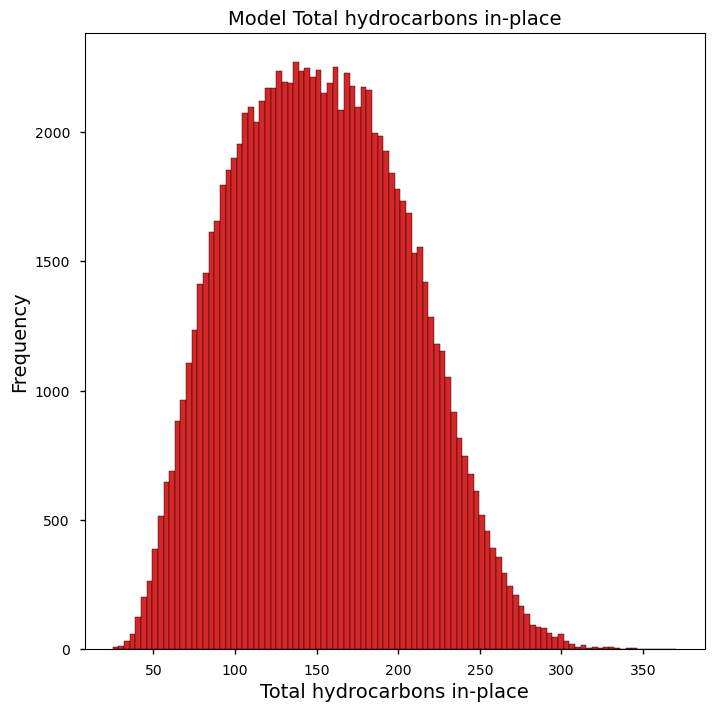

In [23]:
visualize_model_result(model, 100, fontsize=14)

Можно также посмотреть статистику этого распределения

In [24]:
print(vol.stats)

{}


### Гистограммы распределения входных и выходного параметров для каждого из регионов поотдельности

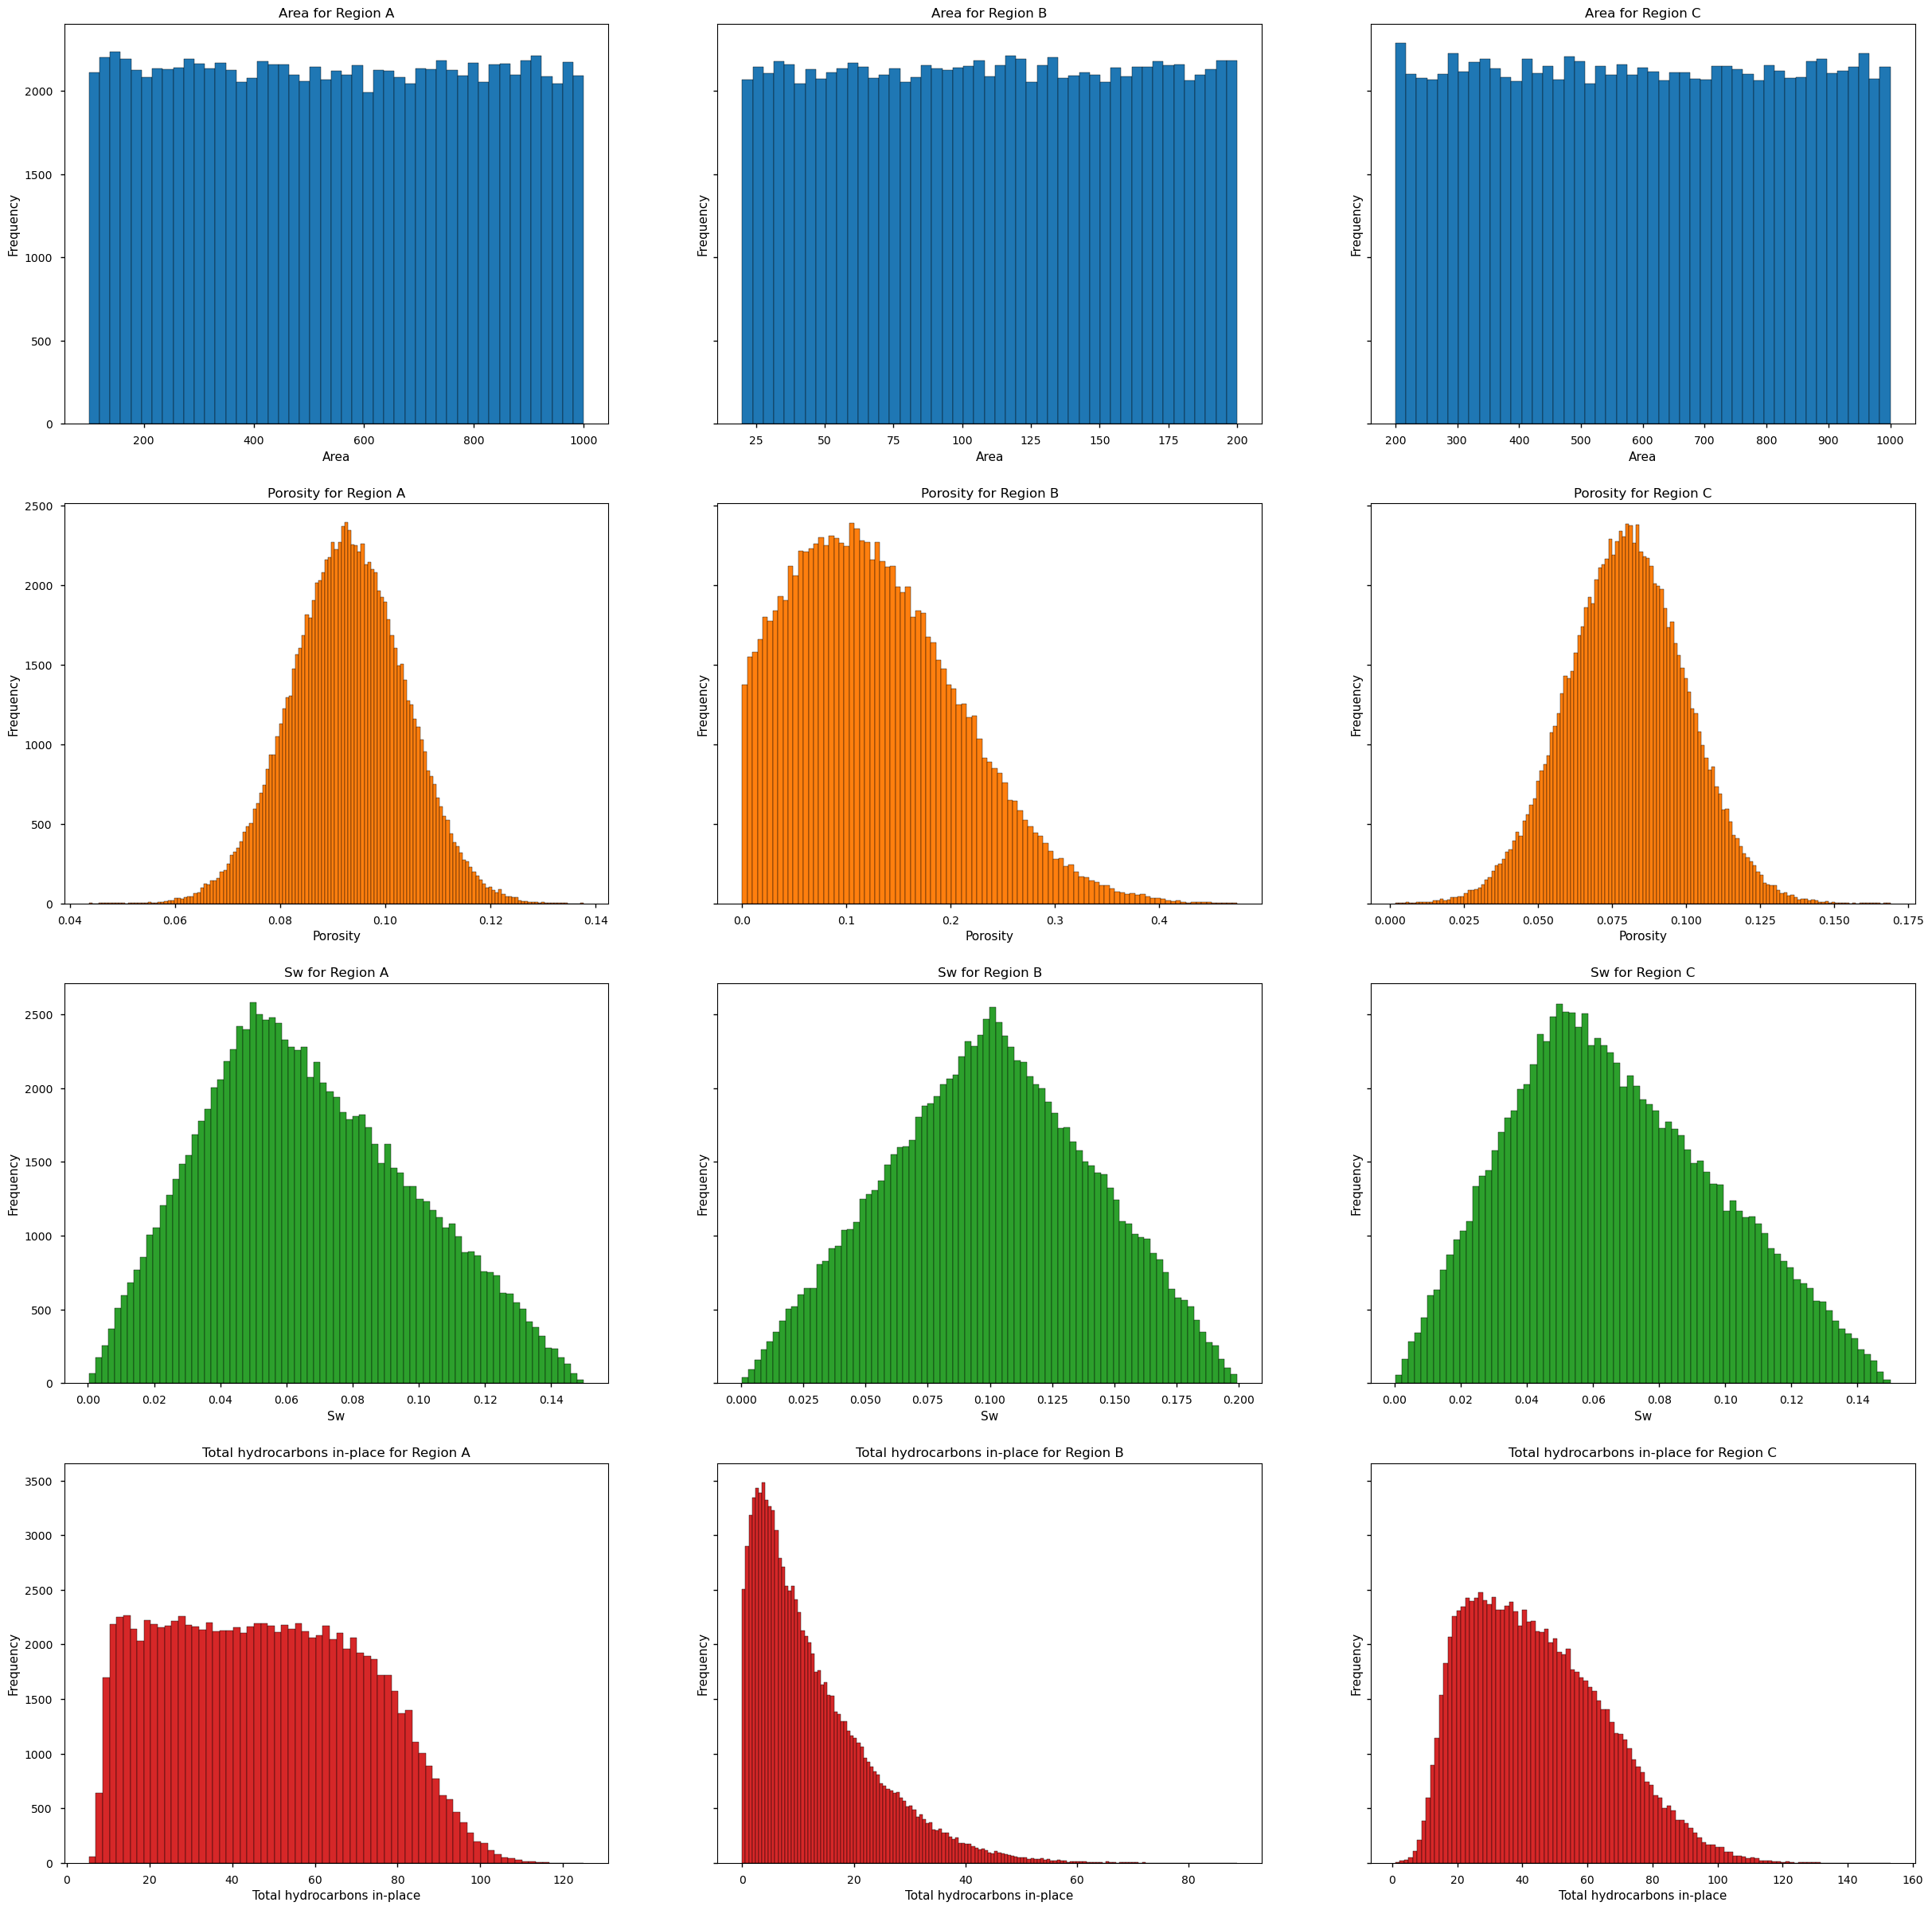

In [25]:
visualize_properties_distributions(model, figsize=(30, 30))

Можно посмотреть и вывести конкретный аттрибут всех свойств в модели (на выбор: как входных, так и выходных или всех сразу)

In [26]:
model.get_all_properties("values", invert_dict=True, include=("results", "inputs"))

{'Area': {'A': array([423.43197901, 585.92216532, 296.71770349, ..., 441.41374407,
         526.4245376 , 220.54236829]),
  'B': array([ 54.68726424,  32.75206674, 145.97075724, ..., 165.03088414,
         168.72907209,  25.51710249]),
  'C': array([201.77723027, 253.65740034, 808.60428453, ..., 902.11255933,
         880.52666573, 263.64512911])},
 'Porosity': {'A': array([0.09863917, 0.08740008, 0.09039165, ..., 0.08985728, 0.06797363,
         0.09124759]),
  'B': array([0.09884095, 0.09790629, 0.28691482, ..., 0.23506063, 0.14219231,
         0.0156766 ]),
  'C': array([0.09631391, 0.08093703, 0.07481071, ..., 0.11487084, 0.06026022,
         0.06417825])},
 'Sw': {'A': array([0.05268122, 0.12968276, 0.02479861, ..., 0.05614261, 0.03463392,
         0.04798405]),
  'B': array([0.13376323, 0.17469465, 0.09801196, ..., 0.10281148, 0.08806108,
         0.13607902]),
  'C': array([0.085603  , 0.05381387, 0.08900493, ..., 0.08939052, 0.09429693,
         0.12285165])},
 'Total hydrocarb

# 8. Сохранение и загрузка модели

Теперь, когда мы провели расчеты, мы можем сохранить модель в файл JSON, чтобы не потерять результаты.   
Эту модель затем можно снова загрузить и снова посчитать статистику и визуализировать.

__to_str__ позволяет контролировать в какой буфер будет выведена модель:
* True - будет возвращен словарь (или текст [я забыл])
* False - будет сохранена в файл с названием, которое мы указали при создании модели

In [29]:
model.to_json(to_str=False)

Загрузка модели из файла (пока не работает нормально)

In [27]:
new_model = Model.from_json('Model OOIP test.json')

KeyError: 'seed'

In [ ]:
print(new_model)

MODEL "OOIP test"
* Seed: 300
* Regions: A, B, C
* Properties: Area, Porosity, Sw, OOIP


# 9. Симуляция нескольких моделей (одинаковых или разных)

ЭТО НАДО ЕЩЁ СДЕЛАТЬ

# 10. Специальные функции для MyGeoMap

In [27]:
model.send_mygeomap()

{'A': {'Total hydrocarbons in-place': array([39.56664382, 44.56863502, 26.15568555, ..., 37.43738277,
         34.54368278, 19.15833055])},
 'B': {'Total hydrocarbons in-place': array([ 4.68230533,  2.64645168, 37.7763176 , ..., 34.80397398,
         21.8792178 ,  0.34558699])},
 'C': {'Total hydrocarbons in-place': array([17.77034905, 19.42546211, 55.10815407, ..., 94.36320331,
         48.05726664, 14.84159885])}}

In [2]:
new_model = Model.receive_mygeomap("Model OOIP test.json")

In [3]:
print(new_model)

MODEL "OOIP test"
* Seed: 300
* Number of samples: 100000
* Regions: A, B, C
* Properties: Area, Porosity, Sw, Total hydrocarbons in-place
